In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.interpolate as interp
import lalsimulation as lal
from tensorflow.keras.callbacks import EarlyStopping
import warnings

2023-07-11 10:04:59.986459: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#inputs

m1_dat = np.loadtxt("m1.dat.txt", dtype=float)
m2_dat = np.loadtxt("m2.dat.txt", dtype=float)
l1_dat = np.loadtxt("l1.dat.txt", dtype=float)
l2_dat = np.loadtxt("l2.dat.txt", dtype=float)

# functions

In [3]:
# inputs are a m1 array, m2 array, l1 array, l2 array, a gamma array of your choice, the 
# string name of that array, the number of epochs, and the patience.

def single_gamma_prediction(m1_dat, m2_dat, l1_dat, l2_dat, gammadat, gamname, num_epochs, patience):
    
    #function for formating the data
    def format_output(data):
        gamma = data.pop(gamname)
        gamma = np.array(gamma)
        return gamma
    
    
    #function for normalizing/whitening the data
    def norm(df):
    
        df_new = pd.DataFrame()
        for k in df.keys():
            df_new[k] = (df[k]-np.mean(df[k])) / np.std(df[k])
        return df_new
    
    
    #create an empty array 4 x length(m1_dat]) for inputs
    array_size =  np.array([[0] * 5 ] * len(m1_dat))
    array_size = array_size.astype('float64')
    combined_array = np.zeros_like(array_size)
    
    
    #reformat data files into this new array
    for i in range(0,len(m1_dat)-1):
        combined_array[i][0] = m1_dat[i]
        combined_array[i][1] = m2_dat[i]
        combined_array[i][2] = l1_dat[i]
        combined_array[i][3] = l2_dat[i]
        combined_array[i][4] = gammadat[i]

    
    data = pd.DataFrame(combined_array)
    data.columns = ['m1','m2', 'l1', 'l2',gamname]
    
    
    #split data into train and test
    data = data.sample(frac=1).reset_index(drop=True)

    train, test = train_test_split(data, test_size=0.2)
    train_stats = train.describe()
    
    
    #get gamma as the outputs and format them as np arrays.
    train_stats.pop(gamname)
    train_stats = train_stats.transpose()
    train_Y = format_output(train)
    test_Y = format_output(test)

    norm_train_X = norm(train)
    norm_test_X = norm(test)
    
    
    #build the model using the functional syntax
    # output will be fed directly from the previous dense layer
    input_layer = Input(shape=(len(train .columns),))
    first_dense = Dense(units='128', activation='selu')(input_layer)
    second_dense = Dense(units='128', activation='selu')(first_dense)

    gamma_output = Dense(units='1', name='gamma_output')(second_dense)
    model = Model(inputs=input_layer, outputs=[gamma_output])

    print(model.summary())
    
    
    #specify the optimizer as stochastic gradient descent and will mention the learning rate as 0.001
    #compile the model with loss functions for both outputs
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                  loss={'gamma_output': 'mse'},
                  metrics={'gamma_output': tf.keras.metrics.Accuracy()})
    
    #train
    history = model.fit(norm_train_X.to_numpy(), train_Y,
                    epochs=num_epochs, batch_size=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001,patience=patience,mode='auto')])
    
    #make predictions, test the model
    gam_predictions = model.predict(norm_test_X.to_numpy())
    
    
    #loss and val_loss are keywords in my history
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    plt.plot(loss_train, 'g', label='Training loss')
    plt.plot(loss_val, 'b', label='validation loss')
    plt.title(gamname + ' training and Validation total loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    
    #return the array of predictions
    return gam_predictions


# gamma_0

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 128)               640       
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 gamma_output (Dense)        (None, 1)                 129       
                                                                 
Total params: 17,281
Trainable params: 17,281
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5000


2023-07-11 10:05:03.860452: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


23/23 [==============================] - 1s 11ms/step - loss: 0.9318 - accuracy: 0.0000e+00 - val_loss: 0.5538 - val_accuracy: 0.0000e+00
Epoch 2/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.4013 - accuracy: 0.0000e+00 - val_loss: 0.2845 - val_accuracy: 0.0000e+00
Epoch 3/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.2077 - accuracy: 0.0000e+00 - val_loss: 0.1804 - val_accuracy: 0.0000e+00
Epoch 4/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.1341 - accuracy: 0.0000e+00 - val_loss: 0.1458 - val_accuracy: 0.0000e+00
Epoch 5/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.1050 - accuracy: 0.0000e+00 - val_loss: 0.1328 - val_accuracy: 0.0000e+00
Epoch 6/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0925 - accuracy: 0.0000e+00 - val_loss: 0.1269 - val_accuracy: 0.0000e+00
Epoch 7/5000
23/23 [==============================] - 0s 2ms/step - loss: 0.0881 - accuracy: 0.0000e+00 - val_lo

23/23 [==============================] - 0s 4ms/step - loss: 0.0772 - accuracy: 0.0000e+00 - val_loss: 0.1205 - val_accuracy: 0.0000e+00
Epoch 56/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0772 - accuracy: 0.0000e+00 - val_loss: 0.1207 - val_accuracy: 0.0000e+00
Epoch 57/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0767 - accuracy: 0.0000e+00 - val_loss: 0.1219 - val_accuracy: 0.0000e+00
Epoch 58/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0768 - accuracy: 0.0000e+00 - val_loss: 0.1220 - val_accuracy: 0.0000e+00
Epoch 59/5000
23/23 [==============================] - 0s 2ms/step - loss: 0.0766 - accuracy: 0.0000e+00 - val_loss: 0.1212 - val_accuracy: 0.0000e+00
Epoch 60/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0766 - accuracy: 0.0000e+00 - val_loss: 0.1222 - val_accuracy: 0.0000e+00
Epoch 61/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0766 - accuracy: 0.0000e+00 - v

23/23 [==============================] - 0s 4ms/step - loss: 0.0711 - accuracy: 0.0000e+00 - val_loss: 0.1177 - val_accuracy: 0.0000e+00
Epoch 110/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0714 - accuracy: 0.0000e+00 - val_loss: 0.1177 - val_accuracy: 0.0000e+00
Epoch 111/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0715 - accuracy: 0.0000e+00 - val_loss: 0.1168 - val_accuracy: 0.0000e+00
Epoch 112/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0709 - accuracy: 0.0000e+00 - val_loss: 0.1153 - val_accuracy: 0.0000e+00
Epoch 113/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0712 - accuracy: 0.0000e+00 - val_loss: 0.1154 - val_accuracy: 0.0000e+00
Epoch 114/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0710 - accuracy: 0.0000e+00 - val_loss: 0.1159 - val_accuracy: 0.0000e+00
Epoch 115/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0705 - accuracy: 0.0000e+

Epoch 163/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0671 - accuracy: 0.0000e+00 - val_loss: 0.1165 - val_accuracy: 0.0000e+00
Epoch 164/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0671 - accuracy: 0.0000e+00 - val_loss: 0.1157 - val_accuracy: 0.0000e+00
Epoch 165/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0672 - accuracy: 0.0000e+00 - val_loss: 0.1177 - val_accuracy: 0.0000e+00
Epoch 166/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0667 - accuracy: 0.0000e+00 - val_loss: 0.1143 - val_accuracy: 0.0000e+00
Epoch 167/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0669 - accuracy: 0.0000e+00 - val_loss: 0.1159 - val_accuracy: 0.0000e+00
Epoch 168/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0668 - accuracy: 0.0000e+00 - val_loss: 0.1149 - val_accuracy: 0.0000e+00
Epoch 169/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0667 - acc

Epoch 217/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0638 - accuracy: 0.0000e+00 - val_loss: 0.1132 - val_accuracy: 0.0000e+00
Epoch 218/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0640 - accuracy: 0.0000e+00 - val_loss: 0.1150 - val_accuracy: 0.0000e+00
Epoch 219/5000
23/23 [==============================] - 0s 6ms/step - loss: 0.0636 - accuracy: 0.0000e+00 - val_loss: 0.1128 - val_accuracy: 0.0000e+00
Epoch 220/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0638 - accuracy: 0.0000e+00 - val_loss: 0.1139 - val_accuracy: 0.0000e+00
Epoch 221/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0635 - accuracy: 0.0000e+00 - val_loss: 0.1166 - val_accuracy: 0.0000e+00
Epoch 222/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0637 - accuracy: 0.0000e+00 - val_loss: 0.1141 - val_accuracy: 0.0000e+00
Epoch 223/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0637 - acc

Epoch 271/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0615 - accuracy: 0.0000e+00 - val_loss: 0.1145 - val_accuracy: 0.0000e+00
Epoch 272/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0612 - accuracy: 0.0000e+00 - val_loss: 0.1141 - val_accuracy: 0.0000e+00
Epoch 273/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0612 - accuracy: 0.0000e+00 - val_loss: 0.1127 - val_accuracy: 0.0000e+00
Epoch 274/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0614 - accuracy: 0.0000e+00 - val_loss: 0.1142 - val_accuracy: 0.0000e+00
Epoch 275/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0613 - accuracy: 0.0000e+00 - val_loss: 0.1141 - val_accuracy: 0.0000e+00
Epoch 276/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0613 - accuracy: 0.0000e+00 - val_loss: 0.1131 - val_accuracy: 0.0000e+00
Epoch 277/5000
23/23 [==============================] - 0s 2ms/step - loss: 0.0611 - acc

Epoch 325/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0593 - accuracy: 0.0000e+00 - val_loss: 0.1147 - val_accuracy: 0.0000e+00
Epoch 326/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0594 - accuracy: 0.0000e+00 - val_loss: 0.1164 - val_accuracy: 0.0000e+00
Epoch 327/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0593 - accuracy: 0.0000e+00 - val_loss: 0.1148 - val_accuracy: 0.0000e+00
Epoch 328/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0594 - accuracy: 0.0000e+00 - val_loss: 0.1149 - val_accuracy: 0.0000e+00
Epoch 329/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0592 - accuracy: 0.0000e+00 - val_loss: 0.1184 - val_accuracy: 0.0000e+00
Epoch 330/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0593 - accuracy: 0.0000e+00 - val_loss: 0.1182 - val_accuracy: 0.0000e+00
Epoch 331/5000
23/23 [==============================] - 0s 5ms/step - loss: 0.0593 - acc

Epoch 379/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0580 - accuracy: 0.0000e+00 - val_loss: 0.1161 - val_accuracy: 0.0000e+00
Epoch 380/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0579 - accuracy: 0.0000e+00 - val_loss: 0.1142 - val_accuracy: 0.0000e+00
Epoch 381/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0578 - accuracy: 0.0000e+00 - val_loss: 0.1133 - val_accuracy: 0.0000e+00
Epoch 382/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0577 - accuracy: 0.0000e+00 - val_loss: 0.1125 - val_accuracy: 0.0000e+00
Epoch 383/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0579 - accuracy: 0.0000e+00 - val_loss: 0.1140 - val_accuracy: 0.0000e+00
Epoch 384/5000
23/23 [==============================] - 0s 6ms/step - loss: 0.0576 - accuracy: 0.0000e+00 - val_loss: 0.1135 - val_accuracy: 0.0000e+00
Epoch 385/5000
23/23 [==============================] - 0s 5ms/step - loss: 0.0579 - acc

Epoch 433/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0561 - accuracy: 0.0000e+00 - val_loss: 0.1204 - val_accuracy: 0.0000e+00
Epoch 434/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0566 - accuracy: 0.0000e+00 - val_loss: 0.1200 - val_accuracy: 0.0000e+00
Epoch 435/5000
23/23 [==============================] - 0s 5ms/step - loss: 0.0565 - accuracy: 0.0000e+00 - val_loss: 0.1228 - val_accuracy: 0.0000e+00
Epoch 436/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0570 - accuracy: 0.0000e+00 - val_loss: 0.1195 - val_accuracy: 0.0000e+00
Epoch 437/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0566 - accuracy: 0.0000e+00 - val_loss: 0.1165 - val_accuracy: 0.0000e+00
Epoch 438/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0564 - accuracy: 0.0000e+00 - val_loss: 0.1203 - val_accuracy: 0.0000e+00
Epoch 439/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0566 - acc

Epoch 487/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0556 - accuracy: 0.0000e+00 - val_loss: 0.1178 - val_accuracy: 0.0000e+00
Epoch 488/5000
23/23 [==============================] - 0s 5ms/step - loss: 0.0553 - accuracy: 0.0000e+00 - val_loss: 0.1154 - val_accuracy: 0.0000e+00
Epoch 489/5000
23/23 [==============================] - 0s 5ms/step - loss: 0.0555 - accuracy: 0.0000e+00 - val_loss: 0.1198 - val_accuracy: 0.0000e+00
Epoch 490/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0553 - accuracy: 0.0000e+00 - val_loss: 0.1179 - val_accuracy: 0.0000e+00
Epoch 491/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0554 - accuracy: 0.0000e+00 - val_loss: 0.1224 - val_accuracy: 0.0000e+00
Epoch 492/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0554 - accuracy: 0.0000e+00 - val_loss: 0.1226 - val_accuracy: 0.0000e+00
Epoch 493/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0554 - acc

Epoch 541/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0545 - accuracy: 0.0000e+00 - val_loss: 0.1209 - val_accuracy: 0.0000e+00
Epoch 542/5000
23/23 [==============================] - 0s 5ms/step - loss: 0.0546 - accuracy: 0.0000e+00 - val_loss: 0.1214 - val_accuracy: 0.0000e+00
Epoch 543/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0547 - accuracy: 0.0000e+00 - val_loss: 0.1220 - val_accuracy: 0.0000e+00
Epoch 544/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0546 - accuracy: 0.0000e+00 - val_loss: 0.1213 - val_accuracy: 0.0000e+00
Epoch 545/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0544 - accuracy: 0.0000e+00 - val_loss: 0.1187 - val_accuracy: 0.0000e+00
Epoch 546/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0542 - accuracy: 0.0000e+00 - val_loss: 0.1250 - val_accuracy: 0.0000e+00
Epoch 547/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0548 - acc

Epoch 595/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0541 - accuracy: 0.0000e+00 - val_loss: 0.1223 - val_accuracy: 0.0000e+00
Epoch 596/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0538 - accuracy: 0.0000e+00 - val_loss: 0.1222 - val_accuracy: 0.0000e+00
Epoch 597/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0536 - accuracy: 0.0000e+00 - val_loss: 0.1203 - val_accuracy: 0.0000e+00
Epoch 598/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0541 - accuracy: 0.0000e+00 - val_loss: 0.1227 - val_accuracy: 0.0000e+00
Epoch 599/5000
23/23 [==============================] - 0s 5ms/step - loss: 0.0536 - accuracy: 0.0000e+00 - val_loss: 0.1259 - val_accuracy: 0.0000e+00
Epoch 600/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0537 - accuracy: 0.0000e+00 - val_loss: 0.1231 - val_accuracy: 0.0000e+00
Epoch 601/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0535 - acc

Epoch 649/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0532 - accuracy: 0.0000e+00 - val_loss: 0.1237 - val_accuracy: 0.0000e+00
Epoch 650/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0529 - accuracy: 0.0000e+00 - val_loss: 0.1277 - val_accuracy: 0.0000e+00
Epoch 651/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0535 - accuracy: 0.0000e+00 - val_loss: 0.1241 - val_accuracy: 0.0000e+00
Epoch 652/5000
23/23 [==============================] - 0s 2ms/step - loss: 0.0534 - accuracy: 0.0000e+00 - val_loss: 0.1268 - val_accuracy: 0.0000e+00
Epoch 653/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0530 - accuracy: 0.0000e+00 - val_loss: 0.1244 - val_accuracy: 0.0000e+00
Epoch 654/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0533 - accuracy: 0.0000e+00 - val_loss: 0.1235 - val_accuracy: 0.0000e+00
Epoch 655/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0534 - acc

Epoch 703/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0525 - accuracy: 0.0000e+00 - val_loss: 0.1256 - val_accuracy: 0.0000e+00
Epoch 704/5000
23/23 [==============================] - 0s 2ms/step - loss: 0.0527 - accuracy: 0.0000e+00 - val_loss: 0.1293 - val_accuracy: 0.0000e+00
Epoch 705/5000
23/23 [==============================] - 0s 2ms/step - loss: 0.0525 - accuracy: 0.0000e+00 - val_loss: 0.1257 - val_accuracy: 0.0000e+00
Epoch 706/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0525 - accuracy: 0.0000e+00 - val_loss: 0.1242 - val_accuracy: 0.0000e+00
Epoch 707/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0527 - accuracy: 0.0000e+00 - val_loss: 0.1233 - val_accuracy: 0.0000e+00
Epoch 708/5000
3/3 [==============================] - 0s 2ms/step


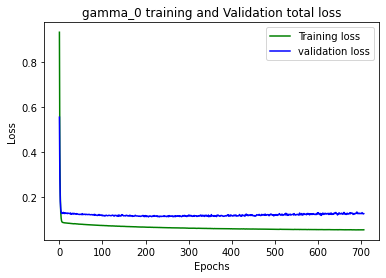

In [4]:
gamma0_dat = np.loadtxt("sd_gamma0.dat.txt", dtype=float)
gamma_0 = single_gamma_prediction(m1_dat, m2_dat, l1_dat, l2_dat, gamma0_dat, "gamma_0",5000,500)

In [5]:
len(gamma_0)

70

# gamma_1

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_2 (Dense)             (None, 128)               640       
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 gamma_output (Dense)        (None, 1)                 129       
                                                                 
Total params: 17,281
Trainable params: 17,281
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5000
23/23 [==============================] - 0s 9ms/step - loss: 0.3104 - accuracy: 0.0000e+00 - val_loss: 0.1479 - val_accuracy: 0.0000e+00
Epoch 2/5000
23/23 [============

23/23 [==============================] - 0s 4ms/step - loss: 0.0546 - accuracy: 0.0000e+00 - val_loss: 0.0537 - val_accuracy: 0.0000e+00
Epoch 50/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0545 - accuracy: 0.0000e+00 - val_loss: 0.0536 - val_accuracy: 0.0000e+00
Epoch 51/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0544 - accuracy: 0.0000e+00 - val_loss: 0.0538 - val_accuracy: 0.0000e+00
Epoch 52/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0544 - accuracy: 0.0000e+00 - val_loss: 0.0530 - val_accuracy: 0.0000e+00
Epoch 53/5000
23/23 [==============================] - 0s 2ms/step - loss: 0.0543 - accuracy: 0.0000e+00 - val_loss: 0.0534 - val_accuracy: 0.0000e+00
Epoch 54/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0542 - accuracy: 0.0000e+00 - val_loss: 0.0533 - val_accuracy: 0.0000e+00
Epoch 55/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0542 - accuracy: 0.0000e+00 - v

23/23 [==============================] - 0s 3ms/step - loss: 0.0518 - accuracy: 0.0000e+00 - val_loss: 0.0518 - val_accuracy: 0.0000e+00
Epoch 104/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0518 - accuracy: 0.0000e+00 - val_loss: 0.0518 - val_accuracy: 0.0000e+00
Epoch 105/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0517 - accuracy: 0.0000e+00 - val_loss: 0.0519 - val_accuracy: 0.0000e+00
Epoch 106/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0518 - accuracy: 0.0000e+00 - val_loss: 0.0517 - val_accuracy: 0.0000e+00
Epoch 107/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0515 - accuracy: 0.0000e+00 - val_loss: 0.0517 - val_accuracy: 0.0000e+00
Epoch 108/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0516 - accuracy: 0.0000e+00 - val_loss: 0.0513 - val_accuracy: 0.0000e+00
Epoch 109/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0515 - accuracy: 0.0000e+

Epoch 157/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0503 - accuracy: 0.0000e+00 - val_loss: 0.0506 - val_accuracy: 0.0000e+00
Epoch 158/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0503 - accuracy: 0.0000e+00 - val_loss: 0.0505 - val_accuracy: 0.0000e+00
Epoch 159/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0501 - accuracy: 0.0000e+00 - val_loss: 0.0504 - val_accuracy: 0.0000e+00
Epoch 160/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0502 - accuracy: 0.0000e+00 - val_loss: 0.0507 - val_accuracy: 0.0000e+00
Epoch 161/5000
23/23 [==============================] - 0s 5ms/step - loss: 0.0499 - accuracy: 0.0000e+00 - val_loss: 0.0508 - val_accuracy: 0.0000e+00
Epoch 162/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0499 - accuracy: 0.0000e+00 - val_loss: 0.0511 - val_accuracy: 0.0000e+00
Epoch 163/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0501 - acc

Epoch 211/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0491 - accuracy: 0.0000e+00 - val_loss: 0.0499 - val_accuracy: 0.0000e+00
Epoch 212/5000
23/23 [==============================] - 0s 5ms/step - loss: 0.0489 - accuracy: 0.0000e+00 - val_loss: 0.0509 - val_accuracy: 0.0000e+00
Epoch 213/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0490 - accuracy: 0.0000e+00 - val_loss: 0.0504 - val_accuracy: 0.0000e+00
Epoch 214/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0489 - accuracy: 0.0000e+00 - val_loss: 0.0506 - val_accuracy: 0.0000e+00
Epoch 215/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0490 - accuracy: 0.0000e+00 - val_loss: 0.0509 - val_accuracy: 0.0000e+00
Epoch 216/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0489 - accuracy: 0.0000e+00 - val_loss: 0.0509 - val_accuracy: 0.0000e+00
Epoch 217/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0488 - acc

Epoch 265/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0482 - accuracy: 0.0000e+00 - val_loss: 0.0504 - val_accuracy: 0.0000e+00
Epoch 266/5000
23/23 [==============================] - 0s 2ms/step - loss: 0.0483 - accuracy: 0.0000e+00 - val_loss: 0.0503 - val_accuracy: 0.0000e+00
Epoch 267/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0484 - accuracy: 0.0000e+00 - val_loss: 0.0510 - val_accuracy: 0.0000e+00
Epoch 268/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0482 - accuracy: 0.0000e+00 - val_loss: 0.0507 - val_accuracy: 0.0000e+00
Epoch 269/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0481 - accuracy: 0.0000e+00 - val_loss: 0.0500 - val_accuracy: 0.0000e+00
Epoch 270/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0482 - accuracy: 0.0000e+00 - val_loss: 0.0500 - val_accuracy: 0.0000e+00
Epoch 271/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0482 - acc

Epoch 319/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0475 - accuracy: 0.0000e+00 - val_loss: 0.0507 - val_accuracy: 0.0000e+00
Epoch 320/5000
23/23 [==============================] - 0s 5ms/step - loss: 0.0476 - accuracy: 0.0000e+00 - val_loss: 0.0500 - val_accuracy: 0.0000e+00
Epoch 321/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0475 - accuracy: 0.0000e+00 - val_loss: 0.0504 - val_accuracy: 0.0000e+00
Epoch 322/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0475 - accuracy: 0.0000e+00 - val_loss: 0.0499 - val_accuracy: 0.0000e+00
Epoch 323/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0476 - accuracy: 0.0000e+00 - val_loss: 0.0507 - val_accuracy: 0.0000e+00
Epoch 324/5000
23/23 [==============================] - 0s 2ms/step - loss: 0.0478 - accuracy: 0.0000e+00 - val_loss: 0.0500 - val_accuracy: 0.0000e+00
Epoch 325/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0475 - acc

Epoch 373/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0471 - accuracy: 0.0000e+00 - val_loss: 0.0498 - val_accuracy: 0.0000e+00
Epoch 374/5000
23/23 [==============================] - 0s 5ms/step - loss: 0.0470 - accuracy: 0.0000e+00 - val_loss: 0.0499 - val_accuracy: 0.0000e+00
Epoch 375/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0470 - accuracy: 0.0000e+00 - val_loss: 0.0494 - val_accuracy: 0.0000e+00
Epoch 376/5000
23/23 [==============================] - 0s 2ms/step - loss: 0.0472 - accuracy: 0.0000e+00 - val_loss: 0.0497 - val_accuracy: 0.0000e+00
Epoch 377/5000
23/23 [==============================] - 0s 5ms/step - loss: 0.0470 - accuracy: 0.0000e+00 - val_loss: 0.0502 - val_accuracy: 0.0000e+00
Epoch 378/5000
23/23 [==============================] - 0s 5ms/step - loss: 0.0472 - accuracy: 0.0000e+00 - val_loss: 0.0499 - val_accuracy: 0.0000e+00
Epoch 379/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0471 - acc

Epoch 427/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0468 - accuracy: 0.0000e+00 - val_loss: 0.0501 - val_accuracy: 0.0000e+00
Epoch 428/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0467 - accuracy: 0.0000e+00 - val_loss: 0.0505 - val_accuracy: 0.0000e+00
Epoch 429/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0467 - accuracy: 0.0000e+00 - val_loss: 0.0512 - val_accuracy: 0.0000e+00
Epoch 430/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0468 - accuracy: 0.0000e+00 - val_loss: 0.0508 - val_accuracy: 0.0000e+00
Epoch 431/5000
23/23 [==============================] - 0s 5ms/step - loss: 0.0466 - accuracy: 0.0000e+00 - val_loss: 0.0501 - val_accuracy: 0.0000e+00
Epoch 432/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0466 - accuracy: 0.0000e+00 - val_loss: 0.0499 - val_accuracy: 0.0000e+00
Epoch 433/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0465 - acc

Epoch 481/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0462 - accuracy: 0.0000e+00 - val_loss: 0.0503 - val_accuracy: 0.0000e+00
Epoch 482/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0464 - accuracy: 0.0000e+00 - val_loss: 0.0506 - val_accuracy: 0.0000e+00
Epoch 483/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0463 - accuracy: 0.0000e+00 - val_loss: 0.0498 - val_accuracy: 0.0000e+00
Epoch 484/5000
23/23 [==============================] - 0s 5ms/step - loss: 0.0463 - accuracy: 0.0000e+00 - val_loss: 0.0501 - val_accuracy: 0.0000e+00
Epoch 485/5000
23/23 [==============================] - 0s 2ms/step - loss: 0.0462 - accuracy: 0.0000e+00 - val_loss: 0.0506 - val_accuracy: 0.0000e+00
Epoch 486/5000
23/23 [==============================] - 0s 5ms/step - loss: 0.0461 - accuracy: 0.0000e+00 - val_loss: 0.0495 - val_accuracy: 0.0000e+00
Epoch 487/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0462 - acc

Epoch 535/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0460 - accuracy: 0.0000e+00 - val_loss: 0.0504 - val_accuracy: 0.0000e+00
Epoch 536/5000
23/23 [==============================] - 0s 5ms/step - loss: 0.0458 - accuracy: 0.0000e+00 - val_loss: 0.0501 - val_accuracy: 0.0000e+00
Epoch 537/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0459 - accuracy: 0.0000e+00 - val_loss: 0.0505 - val_accuracy: 0.0000e+00
Epoch 538/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0459 - accuracy: 0.0000e+00 - val_loss: 0.0503 - val_accuracy: 0.0000e+00
Epoch 539/5000
23/23 [==============================] - 0s 5ms/step - loss: 0.0460 - accuracy: 0.0000e+00 - val_loss: 0.0499 - val_accuracy: 0.0000e+00
Epoch 540/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0458 - accuracy: 0.0000e+00 - val_loss: 0.0499 - val_accuracy: 0.0000e+00
Epoch 541/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0460 - acc

Epoch 589/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0457 - accuracy: 0.0000e+00 - val_loss: 0.0496 - val_accuracy: 0.0000e+00
Epoch 590/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0456 - accuracy: 0.0000e+00 - val_loss: 0.0509 - val_accuracy: 0.0000e+00
Epoch 591/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0458 - accuracy: 0.0000e+00 - val_loss: 0.0506 - val_accuracy: 0.0000e+00
Epoch 592/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0456 - accuracy: 0.0000e+00 - val_loss: 0.0507 - val_accuracy: 0.0000e+00
Epoch 593/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0456 - accuracy: 0.0000e+00 - val_loss: 0.0496 - val_accuracy: 0.0000e+00
Epoch 594/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0457 - accuracy: 0.0000e+00 - val_loss: 0.0501 - val_accuracy: 0.0000e+00
Epoch 595/5000
23/23 [==============================] - 0s 5ms/step - loss: 0.0457 - acc

Epoch 643/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0455 - accuracy: 0.0000e+00 - val_loss: 0.0507 - val_accuracy: 0.0000e+00
Epoch 644/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0454 - accuracy: 0.0000e+00 - val_loss: 0.0499 - val_accuracy: 0.0000e+00
Epoch 645/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0457 - accuracy: 0.0000e+00 - val_loss: 0.0497 - val_accuracy: 0.0000e+00
Epoch 646/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0452 - accuracy: 0.0000e+00 - val_loss: 0.0507 - val_accuracy: 0.0000e+00
Epoch 647/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0454 - accuracy: 0.0000e+00 - val_loss: 0.0502 - val_accuracy: 0.0000e+00
Epoch 648/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0454 - accuracy: 0.0000e+00 - val_loss: 0.0503 - val_accuracy: 0.0000e+00
Epoch 649/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0456 - acc

Epoch 697/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0452 - accuracy: 0.0000e+00 - val_loss: 0.0499 - val_accuracy: 0.0000e+00
Epoch 698/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0451 - accuracy: 0.0000e+00 - val_loss: 0.0499 - val_accuracy: 0.0000e+00
Epoch 699/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0450 - accuracy: 0.0000e+00 - val_loss: 0.0507 - val_accuracy: 0.0000e+00
Epoch 700/5000
23/23 [==============================] - 0s 2ms/step - loss: 0.0452 - accuracy: 0.0000e+00 - val_loss: 0.0507 - val_accuracy: 0.0000e+00
Epoch 701/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0451 - accuracy: 0.0000e+00 - val_loss: 0.0502 - val_accuracy: 0.0000e+00
Epoch 702/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0452 - accuracy: 0.0000e+00 - val_loss: 0.0507 - val_accuracy: 0.0000e+00
Epoch 703/5000
23/23 [==============================] - 0s 2ms/step - loss: 0.0453 - acc

Epoch 751/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0450 - accuracy: 0.0000e+00 - val_loss: 0.0501 - val_accuracy: 0.0000e+00
Epoch 752/5000
23/23 [==============================] - 0s 2ms/step - loss: 0.0451 - accuracy: 0.0000e+00 - val_loss: 0.0502 - val_accuracy: 0.0000e+00
Epoch 753/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0450 - accuracy: 0.0000e+00 - val_loss: 0.0503 - val_accuracy: 0.0000e+00
Epoch 754/5000
23/23 [==============================] - 0s 2ms/step - loss: 0.0449 - accuracy: 0.0000e+00 - val_loss: 0.0502 - val_accuracy: 0.0000e+00
Epoch 755/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0449 - accuracy: 0.0000e+00 - val_loss: 0.0508 - val_accuracy: 0.0000e+00
Epoch 756/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0449 - accuracy: 0.0000e+00 - val_loss: 0.0502 - val_accuracy: 0.0000e+00
Epoch 757/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0449 - acc

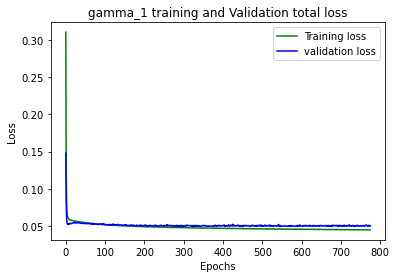

In [6]:
gamma1_dat = np.loadtxt("sd_gamma1.dat.txt", dtype=float)
gamma_1 = single_gamma_prediction(m1_dat, m2_dat, l1_dat, l2_dat, gamma1_dat, "gamma_1",5000,500)

In [7]:
len(gamma_1)

70

# gamma_2

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_4 (Dense)             (None, 128)               640       
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 gamma_output (Dense)        (None, 1)                 129       
                                                                 
Total params: 17,281
Trainable params: 17,281
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5000
23/23 [==============================] - 0s 7ms/step - loss: 0.1900 - accuracy: 0.0000e+00 - val_loss: 0.0542 - val_accuracy: 0.0000e+00
Epoch 2/5000
23/23 [============

23/23 [==============================] - 0s 3ms/step - loss: 0.0038 - accuracy: 0.0000e+00 - val_loss: 0.0036 - val_accuracy: 0.0000e+00
Epoch 50/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0038 - accuracy: 0.0000e+00 - val_loss: 0.0036 - val_accuracy: 0.0000e+00
Epoch 51/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0038 - accuracy: 0.0000e+00 - val_loss: 0.0036 - val_accuracy: 0.0000e+00
Epoch 52/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0038 - accuracy: 0.0000e+00 - val_loss: 0.0036 - val_accuracy: 0.0000e+00
Epoch 53/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0038 - accuracy: 0.0000e+00 - val_loss: 0.0035 - val_accuracy: 0.0000e+00
Epoch 54/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0038 - accuracy: 0.0000e+00 - val_loss: 0.0035 - val_accuracy: 0.0000e+00
Epoch 55/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0038 - accuracy: 0.0000e+00 - v

23/23 [==============================] - 0s 3ms/step - loss: 0.0034 - accuracy: 0.0000e+00 - val_loss: 0.0033 - val_accuracy: 0.0000e+00
Epoch 104/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0034 - accuracy: 0.0000e+00 - val_loss: 0.0033 - val_accuracy: 0.0000e+00
Epoch 105/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0034 - accuracy: 0.0000e+00 - val_loss: 0.0033 - val_accuracy: 0.0000e+00
Epoch 106/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0034 - accuracy: 0.0000e+00 - val_loss: 0.0033 - val_accuracy: 0.0000e+00
Epoch 107/5000
23/23 [==============================] - 0s 5ms/step - loss: 0.0034 - accuracy: 0.0000e+00 - val_loss: 0.0033 - val_accuracy: 0.0000e+00
Epoch 108/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0034 - accuracy: 0.0000e+00 - val_loss: 0.0033 - val_accuracy: 0.0000e+00
Epoch 109/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0034 - accuracy: 0.0000e+

Epoch 157/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0032 - accuracy: 0.0000e+00 - val_loss: 0.0032 - val_accuracy: 0.0000e+00
Epoch 158/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0032 - accuracy: 0.0000e+00 - val_loss: 0.0032 - val_accuracy: 0.0000e+00
Epoch 159/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0032 - accuracy: 0.0000e+00 - val_loss: 0.0032 - val_accuracy: 0.0000e+00
Epoch 160/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0032 - accuracy: 0.0000e+00 - val_loss: 0.0032 - val_accuracy: 0.0000e+00
Epoch 161/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0032 - accuracy: 0.0000e+00 - val_loss: 0.0032 - val_accuracy: 0.0000e+00
Epoch 162/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0032 - accuracy: 0.0000e+00 - val_loss: 0.0032 - val_accuracy: 0.0000e+00
Epoch 163/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0032 - acc

Epoch 211/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0030 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 212/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0030 - accuracy: 0.0000e+00 - val_loss: 0.0032 - val_accuracy: 0.0000e+00
Epoch 213/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0030 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 214/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0030 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 215/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0030 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 216/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0030 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 217/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0030 - acc

Epoch 265/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0029 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 266/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0029 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 267/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0029 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 268/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0029 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 269/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0029 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 270/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0029 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 271/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0029 - acc

Epoch 319/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0028 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 320/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0028 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 321/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0028 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 322/5000
23/23 [==============================] - 0s 2ms/step - loss: 0.0028 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 323/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0028 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 324/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0028 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 325/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0028 - acc

Epoch 373/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0028 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 374/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0028 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 375/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0028 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 376/5000
23/23 [==============================] - 0s 5ms/step - loss: 0.0028 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 377/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0028 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 378/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0028 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 379/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0028 - acc

Epoch 427/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0027 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 428/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0027 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 429/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0027 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 430/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0027 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 431/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0027 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 432/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0027 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 433/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0027 - acc

Epoch 481/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0027 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 482/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0027 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 483/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0027 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 484/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0027 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 485/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0027 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 486/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0027 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 487/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0027 - acc

Epoch 535/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0026 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 536/5000
23/23 [==============================] - 0s 5ms/step - loss: 0.0026 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 537/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0026 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 538/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0026 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 539/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0026 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 540/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0026 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 541/5000
23/23 [==============================] - 0s 5ms/step - loss: 0.0026 - acc

Epoch 589/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0026 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 590/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0026 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 591/5000
23/23 [==============================] - 0s 5ms/step - loss: 0.0026 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 592/5000
23/23 [==============================] - 0s 5ms/step - loss: 0.0026 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 593/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0026 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 594/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0026 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 595/5000
23/23 [==============================] - 0s 5ms/step - loss: 0.0026 - acc

Epoch 643/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0025 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 644/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0026 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 645/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0025 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 646/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0025 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 647/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0025 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 648/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0025 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 649/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0025 - acc

Epoch 697/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0025 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 698/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0025 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 699/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0025 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 700/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0025 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 701/5000
23/23 [==============================] - 0s 2ms/step - loss: 0.0025 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 702/5000
23/23 [==============================] - 0s 2ms/step - loss: 0.0025 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 703/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.0025 - acc

Epoch 751/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.0025 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 752/5000
3/3 [==============================] - 0s 2ms/step


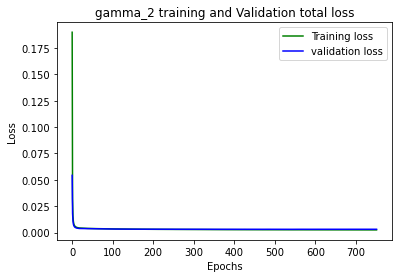

In [8]:
gamma2_dat = np.loadtxt("sd_gamma2.dat.txt", dtype=float)
gamma_2 = single_gamma_prediction(m1_dat, m2_dat, l1_dat, l2_dat, gamma2_dat, "gamma_2",5000,500)

In [9]:
len(gamma_2)

70

# gamma_3

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_6 (Dense)             (None, 128)               640       
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                                 
 gamma_output (Dense)        (None, 1)                 129       
                                                                 
Total params: 17,281
Trainable params: 17,281
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5000
23/23 [==============================] - 0s 7ms/step - loss: 0.3668 - accuracy: 0.0000e+00 - val_loss: 0.1385 - val_accuracy: 0.0000e+00
Epoch 2/5000
23/23 [============

23/23 [==============================] - 0s 3ms/step - loss: 7.0242e-04 - accuracy: 0.0000e+00 - val_loss: 0.0029 - val_accuracy: 0.0000e+00
Epoch 49/5000
23/23 [==============================] - 0s 3ms/step - loss: 6.9357e-04 - accuracy: 0.0000e+00 - val_loss: 0.0028 - val_accuracy: 0.0000e+00
Epoch 50/5000
23/23 [==============================] - 0s 4ms/step - loss: 7.0113e-04 - accuracy: 0.0000e+00 - val_loss: 0.0029 - val_accuracy: 0.0000e+00
Epoch 51/5000
23/23 [==============================] - 0s 2ms/step - loss: 6.8866e-04 - accuracy: 0.0000e+00 - val_loss: 0.0029 - val_accuracy: 0.0000e+00
Epoch 52/5000
23/23 [==============================] - 0s 4ms/step - loss: 6.8477e-04 - accuracy: 0.0000e+00 - val_loss: 0.0029 - val_accuracy: 0.0000e+00
Epoch 53/5000
23/23 [==============================] - 0s 3ms/step - loss: 6.7567e-04 - accuracy: 0.0000e+00 - val_loss: 0.0028 - val_accuracy: 0.0000e+00
Epoch 54/5000
23/23 [==============================] - 0s 5ms/step - loss: 6.7132e-0

Epoch 101/5000
23/23 [==============================] - 0s 3ms/step - loss: 4.8011e-04 - accuracy: 0.0000e+00 - val_loss: 0.0028 - val_accuracy: 0.0000e+00
Epoch 102/5000
23/23 [==============================] - 0s 4ms/step - loss: 4.7733e-04 - accuracy: 0.0000e+00 - val_loss: 0.0027 - val_accuracy: 0.0000e+00
Epoch 103/5000
23/23 [==============================] - 0s 6ms/step - loss: 4.7424e-04 - accuracy: 0.0000e+00 - val_loss: 0.0027 - val_accuracy: 0.0000e+00
Epoch 104/5000
23/23 [==============================] - 0s 4ms/step - loss: 4.7607e-04 - accuracy: 0.0000e+00 - val_loss: 0.0027 - val_accuracy: 0.0000e+00
Epoch 105/5000
23/23 [==============================] - 0s 3ms/step - loss: 4.6615e-04 - accuracy: 0.0000e+00 - val_loss: 0.0027 - val_accuracy: 0.0000e+00
Epoch 106/5000
23/23 [==============================] - 0s 3ms/step - loss: 4.6477e-04 - accuracy: 0.0000e+00 - val_loss: 0.0028 - val_accuracy: 0.0000e+00
Epoch 107/5000
23/23 [==============================] - 0s 4ms/s

23/23 [==============================] - 0s 3ms/step - loss: 3.6467e-04 - accuracy: 0.0000e+00 - val_loss: 0.0026 - val_accuracy: 0.0000e+00
Epoch 154/5000
23/23 [==============================] - 0s 3ms/step - loss: 3.6380e-04 - accuracy: 0.0000e+00 - val_loss: 0.0027 - val_accuracy: 0.0000e+00
Epoch 155/5000
23/23 [==============================] - 0s 3ms/step - loss: 3.5929e-04 - accuracy: 0.0000e+00 - val_loss: 0.0026 - val_accuracy: 0.0000e+00
Epoch 156/5000
23/23 [==============================] - 0s 3ms/step - loss: 3.6120e-04 - accuracy: 0.0000e+00 - val_loss: 0.0027 - val_accuracy: 0.0000e+00
Epoch 157/5000
23/23 [==============================] - 0s 4ms/step - loss: 3.5800e-04 - accuracy: 0.0000e+00 - val_loss: 0.0026 - val_accuracy: 0.0000e+00
Epoch 158/5000
23/23 [==============================] - 0s 2ms/step - loss: 3.5456e-04 - accuracy: 0.0000e+00 - val_loss: 0.0026 - val_accuracy: 0.0000e+00
Epoch 159/5000
23/23 [==============================] - 0s 4ms/step - loss: 3.5

23/23 [==============================] - 0s 4ms/step - loss: 2.9537e-04 - accuracy: 0.0000e+00 - val_loss: 0.0026 - val_accuracy: 0.0000e+00
Epoch 206/5000
23/23 [==============================] - 0s 4ms/step - loss: 2.9553e-04 - accuracy: 0.0000e+00 - val_loss: 0.0026 - val_accuracy: 0.0000e+00
Epoch 207/5000
23/23 [==============================] - 0s 4ms/step - loss: 2.9357e-04 - accuracy: 0.0000e+00 - val_loss: 0.0026 - val_accuracy: 0.0000e+00
Epoch 208/5000
23/23 [==============================] - 0s 4ms/step - loss: 2.9377e-04 - accuracy: 0.0000e+00 - val_loss: 0.0025 - val_accuracy: 0.0000e+00
Epoch 209/5000
23/23 [==============================] - 0s 4ms/step - loss: 2.9229e-04 - accuracy: 0.0000e+00 - val_loss: 0.0025 - val_accuracy: 0.0000e+00
Epoch 210/5000
23/23 [==============================] - 0s 4ms/step - loss: 2.8920e-04 - accuracy: 0.0000e+00 - val_loss: 0.0026 - val_accuracy: 0.0000e+00
Epoch 211/5000
23/23 [==============================] - 0s 4ms/step - loss: 2.8

23/23 [==============================] - 0s 4ms/step - loss: 2.5122e-04 - accuracy: 0.0000e+00 - val_loss: 0.0025 - val_accuracy: 0.0000e+00
Epoch 258/5000
23/23 [==============================] - 0s 3ms/step - loss: 2.4879e-04 - accuracy: 0.0000e+00 - val_loss: 0.0024 - val_accuracy: 0.0000e+00
Epoch 259/5000
23/23 [==============================] - 0s 3ms/step - loss: 2.5000e-04 - accuracy: 0.0000e+00 - val_loss: 0.0024 - val_accuracy: 0.0000e+00
Epoch 260/5000
23/23 [==============================] - 0s 3ms/step - loss: 2.4655e-04 - accuracy: 0.0000e+00 - val_loss: 0.0024 - val_accuracy: 0.0000e+00
Epoch 261/5000
23/23 [==============================] - 0s 3ms/step - loss: 2.4692e-04 - accuracy: 0.0000e+00 - val_loss: 0.0024 - val_accuracy: 0.0000e+00
Epoch 262/5000
23/23 [==============================] - 0s 3ms/step - loss: 2.4559e-04 - accuracy: 0.0000e+00 - val_loss: 0.0024 - val_accuracy: 0.0000e+00
Epoch 263/5000
23/23 [==============================] - 0s 4ms/step - loss: 2.4

23/23 [==============================] - 0s 3ms/step - loss: 2.1701e-04 - accuracy: 0.0000e+00 - val_loss: 0.0023 - val_accuracy: 0.0000e+00
Epoch 310/5000
23/23 [==============================] - 0s 4ms/step - loss: 2.1675e-04 - accuracy: 0.0000e+00 - val_loss: 0.0024 - val_accuracy: 0.0000e+00
Epoch 311/5000
23/23 [==============================] - 0s 4ms/step - loss: 2.1731e-04 - accuracy: 0.0000e+00 - val_loss: 0.0024 - val_accuracy: 0.0000e+00
Epoch 312/5000
23/23 [==============================] - 0s 4ms/step - loss: 2.1580e-04 - accuracy: 0.0000e+00 - val_loss: 0.0024 - val_accuracy: 0.0000e+00
Epoch 313/5000
23/23 [==============================] - 0s 4ms/step - loss: 2.1576e-04 - accuracy: 0.0000e+00 - val_loss: 0.0024 - val_accuracy: 0.0000e+00
Epoch 314/5000
23/23 [==============================] - 0s 4ms/step - loss: 2.1515e-04 - accuracy: 0.0000e+00 - val_loss: 0.0024 - val_accuracy: 0.0000e+00
Epoch 315/5000
23/23 [==============================] - 0s 4ms/step - loss: 2.1

23/23 [==============================] - 0s 3ms/step - loss: 1.9276e-04 - accuracy: 0.0000e+00 - val_loss: 0.0023 - val_accuracy: 0.0000e+00
Epoch 362/5000
23/23 [==============================] - 0s 4ms/step - loss: 1.9183e-04 - accuracy: 0.0000e+00 - val_loss: 0.0023 - val_accuracy: 0.0000e+00
Epoch 363/5000
23/23 [==============================] - 0s 5ms/step - loss: 1.9111e-04 - accuracy: 0.0000e+00 - val_loss: 0.0022 - val_accuracy: 0.0000e+00
Epoch 364/5000
23/23 [==============================] - 0s 4ms/step - loss: 1.9036e-04 - accuracy: 0.0000e+00 - val_loss: 0.0023 - val_accuracy: 0.0000e+00
Epoch 365/5000
23/23 [==============================] - 0s 5ms/step - loss: 1.9054e-04 - accuracy: 0.0000e+00 - val_loss: 0.0023 - val_accuracy: 0.0000e+00
Epoch 366/5000
23/23 [==============================] - 0s 3ms/step - loss: 1.9121e-04 - accuracy: 0.0000e+00 - val_loss: 0.0023 - val_accuracy: 0.0000e+00
Epoch 367/5000
23/23 [==============================] - 0s 3ms/step - loss: 1.8

23/23 [==============================] - 0s 3ms/step - loss: 1.7235e-04 - accuracy: 0.0000e+00 - val_loss: 0.0022 - val_accuracy: 0.0000e+00
Epoch 414/5000
23/23 [==============================] - 0s 3ms/step - loss: 1.7280e-04 - accuracy: 0.0000e+00 - val_loss: 0.0022 - val_accuracy: 0.0000e+00
Epoch 415/5000
23/23 [==============================] - 0s 3ms/step - loss: 1.7217e-04 - accuracy: 0.0000e+00 - val_loss: 0.0022 - val_accuracy: 0.0000e+00
Epoch 416/5000
23/23 [==============================] - 0s 4ms/step - loss: 1.7121e-04 - accuracy: 0.0000e+00 - val_loss: 0.0022 - val_accuracy: 0.0000e+00
Epoch 417/5000
23/23 [==============================] - 0s 4ms/step - loss: 1.7096e-04 - accuracy: 0.0000e+00 - val_loss: 0.0022 - val_accuracy: 0.0000e+00
Epoch 418/5000
23/23 [==============================] - 0s 4ms/step - loss: 1.7051e-04 - accuracy: 0.0000e+00 - val_loss: 0.0022 - val_accuracy: 0.0000e+00
Epoch 419/5000
23/23 [==============================] - 0s 4ms/step - loss: 1.7

23/23 [==============================] - 0s 4ms/step - loss: 1.5512e-04 - accuracy: 0.0000e+00 - val_loss: 0.0021 - val_accuracy: 0.0000e+00
Epoch 466/5000
23/23 [==============================] - 0s 5ms/step - loss: 1.5618e-04 - accuracy: 0.0000e+00 - val_loss: 0.0021 - val_accuracy: 0.0000e+00
Epoch 467/5000
23/23 [==============================] - 0s 4ms/step - loss: 1.5552e-04 - accuracy: 0.0000e+00 - val_loss: 0.0021 - val_accuracy: 0.0000e+00
Epoch 468/5000
23/23 [==============================] - 0s 4ms/step - loss: 1.5458e-04 - accuracy: 0.0000e+00 - val_loss: 0.0021 - val_accuracy: 0.0000e+00
Epoch 469/5000
23/23 [==============================] - 0s 4ms/step - loss: 1.5519e-04 - accuracy: 0.0000e+00 - val_loss: 0.0021 - val_accuracy: 0.0000e+00
Epoch 470/5000
23/23 [==============================] - 0s 3ms/step - loss: 1.5488e-04 - accuracy: 0.0000e+00 - val_loss: 0.0021 - val_accuracy: 0.0000e+00
Epoch 471/5000
23/23 [==============================] - 0s 3ms/step - loss: 1.5

23/23 [==============================] - 0s 4ms/step - loss: 1.4170e-04 - accuracy: 0.0000e+00 - val_loss: 0.0020 - val_accuracy: 0.0000e+00
Epoch 518/5000
23/23 [==============================] - 0s 2ms/step - loss: 1.4226e-04 - accuracy: 0.0000e+00 - val_loss: 0.0020 - val_accuracy: 0.0000e+00
Epoch 519/5000
23/23 [==============================] - 0s 4ms/step - loss: 1.4156e-04 - accuracy: 0.0000e+00 - val_loss: 0.0020 - val_accuracy: 0.0000e+00
Epoch 520/5000
23/23 [==============================] - 0s 3ms/step - loss: 1.4089e-04 - accuracy: 0.0000e+00 - val_loss: 0.0020 - val_accuracy: 0.0000e+00
Epoch 521/5000
23/23 [==============================] - 0s 3ms/step - loss: 1.4116e-04 - accuracy: 0.0000e+00 - val_loss: 0.0020 - val_accuracy: 0.0000e+00
Epoch 522/5000
23/23 [==============================] - 0s 3ms/step - loss: 1.4155e-04 - accuracy: 0.0000e+00 - val_loss: 0.0020 - val_accuracy: 0.0000e+00
Epoch 523/5000
23/23 [==============================] - 0s 4ms/step - loss: 1.4

23/23 [==============================] - 0s 2ms/step - loss: 1.3087e-04 - accuracy: 0.0000e+00 - val_loss: 0.0020 - val_accuracy: 0.0000e+00
Epoch 570/5000
23/23 [==============================] - 0s 3ms/step - loss: 1.3016e-04 - accuracy: 0.0000e+00 - val_loss: 0.0020 - val_accuracy: 0.0000e+00
Epoch 571/5000
23/23 [==============================] - 0s 3ms/step - loss: 1.3075e-04 - accuracy: 0.0000e+00 - val_loss: 0.0020 - val_accuracy: 0.0000e+00
Epoch 572/5000
23/23 [==============================] - 0s 3ms/step - loss: 1.2999e-04 - accuracy: 0.0000e+00 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 573/5000
23/23 [==============================] - 0s 3ms/step - loss: 1.2970e-04 - accuracy: 0.0000e+00 - val_loss: 0.0020 - val_accuracy: 0.0000e+00
Epoch 574/5000
23/23 [==============================] - 0s 3ms/step - loss: 1.2878e-04 - accuracy: 0.0000e+00 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 575/5000
23/23 [==============================] - 0s 4ms/step - loss: 1.2

23/23 [==============================] - 0s 3ms/step - loss: 1.2057e-04 - accuracy: 0.0000e+00 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 622/5000
23/23 [==============================] - 0s 4ms/step - loss: 1.2012e-04 - accuracy: 0.0000e+00 - val_loss: 0.0020 - val_accuracy: 0.0000e+00
Epoch 623/5000
23/23 [==============================] - 0s 4ms/step - loss: 1.2029e-04 - accuracy: 0.0000e+00 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 624/5000
23/23 [==============================] - 0s 4ms/step - loss: 1.2015e-04 - accuracy: 0.0000e+00 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 625/5000
23/23 [==============================] - 0s 4ms/step - loss: 1.1981e-04 - accuracy: 0.0000e+00 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 626/5000
23/23 [==============================] - 0s 4ms/step - loss: 1.2013e-04 - accuracy: 0.0000e+00 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 627/5000
23/23 [==============================] - 0s 4ms/step - loss: 1.1

23/23 [==============================] - 0s 5ms/step - loss: 1.1225e-04 - accuracy: 0.0000e+00 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 674/5000
23/23 [==============================] - 0s 6ms/step - loss: 1.1164e-04 - accuracy: 0.0000e+00 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 675/5000
23/23 [==============================] - 0s 3ms/step - loss: 1.1140e-04 - accuracy: 0.0000e+00 - val_loss: 0.0018 - val_accuracy: 0.0000e+00
Epoch 676/5000
23/23 [==============================] - 0s 5ms/step - loss: 1.1128e-04 - accuracy: 0.0000e+00 - val_loss: 0.0018 - val_accuracy: 0.0000e+00
Epoch 677/5000
23/23 [==============================] - 0s 3ms/step - loss: 1.1071e-04 - accuracy: 0.0000e+00 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 678/5000
23/23 [==============================] - 0s 4ms/step - loss: 1.1086e-04 - accuracy: 0.0000e+00 - val_loss: 0.0018 - val_accuracy: 0.0000e+00
Epoch 679/5000
23/23 [==============================] - 0s 4ms/step - loss: 1.1

23/23 [==============================] - 0s 5ms/step - loss: 1.0433e-04 - accuracy: 0.0000e+00 - val_loss: 0.0018 - val_accuracy: 0.0000e+00
Epoch 726/5000
23/23 [==============================] - 0s 3ms/step - loss: 1.0360e-04 - accuracy: 0.0000e+00 - val_loss: 0.0018 - val_accuracy: 0.0000e+00
Epoch 727/5000
23/23 [==============================] - 0s 2ms/step - loss: 1.0429e-04 - accuracy: 0.0000e+00 - val_loss: 0.0018 - val_accuracy: 0.0000e+00
Epoch 728/5000
23/23 [==============================] - 0s 5ms/step - loss: 1.0390e-04 - accuracy: 0.0000e+00 - val_loss: 0.0018 - val_accuracy: 0.0000e+00
Epoch 729/5000
23/23 [==============================] - 0s 5ms/step - loss: 1.0330e-04 - accuracy: 0.0000e+00 - val_loss: 0.0018 - val_accuracy: 0.0000e+00
Epoch 730/5000
23/23 [==============================] - 0s 5ms/step - loss: 1.0332e-04 - accuracy: 0.0000e+00 - val_loss: 0.0018 - val_accuracy: 0.0000e+00
Epoch 731/5000
23/23 [==============================] - 0s 4ms/step - loss: 1.0

23/23 [==============================] - 0s 3ms/step - loss: 9.8032e-05 - accuracy: 0.0000e+00 - val_loss: 0.0018 - val_accuracy: 0.0000e+00
Epoch 778/5000
23/23 [==============================] - 0s 4ms/step - loss: 9.7052e-05 - accuracy: 0.0000e+00 - val_loss: 0.0018 - val_accuracy: 0.0000e+00
Epoch 779/5000
23/23 [==============================] - 0s 7ms/step - loss: 9.6964e-05 - accuracy: 0.0000e+00 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 780/5000
23/23 [==============================] - 0s 5ms/step - loss: 9.6956e-05 - accuracy: 0.0000e+00 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 781/5000
23/23 [==============================] - 0s 4ms/step - loss: 9.6903e-05 - accuracy: 0.0000e+00 - val_loss: 0.0018 - val_accuracy: 0.0000e+00
Epoch 782/5000
23/23 [==============================] - 0s 3ms/step - loss: 9.6188e-05 - accuracy: 0.0000e+00 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 783/5000
23/23 [==============================] - 0s 4ms/step - loss: 9.5

23/23 [==============================] - 0s 4ms/step - loss: 9.1433e-05 - accuracy: 0.0000e+00 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 830/5000
23/23 [==============================] - 0s 4ms/step - loss: 9.2305e-05 - accuracy: 0.0000e+00 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 831/5000
23/23 [==============================] - 0s 5ms/step - loss: 9.1445e-05 - accuracy: 0.0000e+00 - val_loss: 0.0018 - val_accuracy: 0.0000e+00
Epoch 832/5000
23/23 [==============================] - 0s 4ms/step - loss: 9.2067e-05 - accuracy: 0.0000e+00 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 833/5000
23/23 [==============================] - 0s 4ms/step - loss: 9.0895e-05 - accuracy: 0.0000e+00 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 834/5000
23/23 [==============================] - 0s 3ms/step - loss: 9.1153e-05 - accuracy: 0.0000e+00 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 835/5000
23/23 [==============================] - 0s 4ms/step - loss: 9.1

23/23 [==============================] - 0s 3ms/step - loss: 8.6290e-05 - accuracy: 0.0000e+00 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 882/5000
23/23 [==============================] - 0s 3ms/step - loss: 8.6098e-05 - accuracy: 0.0000e+00 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 883/5000
23/23 [==============================] - 0s 3ms/step - loss: 8.6315e-05 - accuracy: 0.0000e+00 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 884/5000
23/23 [==============================] - 0s 3ms/step - loss: 8.6248e-05 - accuracy: 0.0000e+00 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 885/5000
23/23 [==============================] - 0s 3ms/step - loss: 8.6355e-05 - accuracy: 0.0000e+00 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 886/5000
23/23 [==============================] - 0s 4ms/step - loss: 8.5813e-05 - accuracy: 0.0000e+00 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 887/5000
23/23 [==============================] - 0s 2ms/step - loss: 8.6

23/23 [==============================] - 0s 3ms/step - loss: 8.1726e-05 - accuracy: 0.0000e+00 - val_loss: 0.0016 - val_accuracy: 0.0000e+00
Epoch 934/5000
23/23 [==============================] - 0s 4ms/step - loss: 8.1103e-05 - accuracy: 0.0000e+00 - val_loss: 0.0016 - val_accuracy: 0.0000e+00
Epoch 935/5000
23/23 [==============================] - 0s 4ms/step - loss: 8.1074e-05 - accuracy: 0.0000e+00 - val_loss: 0.0016 - val_accuracy: 0.0000e+00
Epoch 936/5000
23/23 [==============================] - 0s 4ms/step - loss: 8.1540e-05 - accuracy: 0.0000e+00 - val_loss: 0.0016 - val_accuracy: 0.0000e+00
Epoch 937/5000
23/23 [==============================] - 0s 4ms/step - loss: 8.1329e-05 - accuracy: 0.0000e+00 - val_loss: 0.0016 - val_accuracy: 0.0000e+00
Epoch 938/5000
23/23 [==============================] - 0s 4ms/step - loss: 8.1369e-05 - accuracy: 0.0000e+00 - val_loss: 0.0016 - val_accuracy: 0.0000e+00
Epoch 939/5000
23/23 [==============================] - 0s 4ms/step - loss: 8.1

23/23 [==============================] - 0s 4ms/step - loss: 7.7249e-05 - accuracy: 0.0000e+00 - val_loss: 0.0016 - val_accuracy: 0.0000e+00
Epoch 986/5000
23/23 [==============================] - 0s 5ms/step - loss: 7.7357e-05 - accuracy: 0.0000e+00 - val_loss: 0.0016 - val_accuracy: 0.0000e+00
Epoch 987/5000
23/23 [==============================] - 0s 5ms/step - loss: 7.7479e-05 - accuracy: 0.0000e+00 - val_loss: 0.0016 - val_accuracy: 0.0000e+00
Epoch 988/5000
23/23 [==============================] - 0s 4ms/step - loss: 7.7273e-05 - accuracy: 0.0000e+00 - val_loss: 0.0016 - val_accuracy: 0.0000e+00
Epoch 989/5000
23/23 [==============================] - 0s 3ms/step - loss: 7.7407e-05 - accuracy: 0.0000e+00 - val_loss: 0.0016 - val_accuracy: 0.0000e+00
Epoch 990/5000
23/23 [==============================] - 0s 3ms/step - loss: 7.7286e-05 - accuracy: 0.0000e+00 - val_loss: 0.0016 - val_accuracy: 0.0000e+00
Epoch 991/5000
23/23 [==============================] - 0s 4ms/step - loss: 7.7

23/23 [==============================] - 0s 2ms/step - loss: 7.3867e-05 - accuracy: 0.0000e+00 - val_loss: 0.0016 - val_accuracy: 0.0000e+00
Epoch 1038/5000
23/23 [==============================] - 0s 2ms/step - loss: 7.3531e-05 - accuracy: 0.0000e+00 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 1039/5000
23/23 [==============================] - 0s 2ms/step - loss: 7.3795e-05 - accuracy: 0.0000e+00 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 1040/5000
23/23 [==============================] - 0s 3ms/step - loss: 7.3698e-05 - accuracy: 0.0000e+00 - val_loss: 0.0016 - val_accuracy: 0.0000e+00
Epoch 1041/5000
23/23 [==============================] - 0s 3ms/step - loss: 7.3829e-05 - accuracy: 0.0000e+00 - val_loss: 0.0016 - val_accuracy: 0.0000e+00
Epoch 1042/5000
23/23 [==============================] - 0s 3ms/step - loss: 7.3823e-05 - accuracy: 0.0000e+00 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 1043/5000
23/23 [==============================] - 0s 3ms/step - los

23/23 [==============================] - 0s 4ms/step - loss: 7.0335e-05 - accuracy: 0.0000e+00 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 1090/5000
23/23 [==============================] - 0s 3ms/step - loss: 7.0444e-05 - accuracy: 0.0000e+00 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 1091/5000
23/23 [==============================] - 0s 3ms/step - loss: 7.0305e-05 - accuracy: 0.0000e+00 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 1092/5000
23/23 [==============================] - 0s 3ms/step - loss: 7.0634e-05 - accuracy: 0.0000e+00 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 1093/5000
23/23 [==============================] - 0s 4ms/step - loss: 7.0315e-05 - accuracy: 0.0000e+00 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 1094/5000
23/23 [==============================] - 0s 3ms/step - loss: 7.0582e-05 - accuracy: 0.0000e+00 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 1095/5000
23/23 [==============================] - 0s 3ms/step - los

23/23 [==============================] - 0s 4ms/step - loss: 6.7948e-05 - accuracy: 0.0000e+00 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 1142/5000
23/23 [==============================] - 0s 3ms/step - loss: 6.7127e-05 - accuracy: 0.0000e+00 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 1143/5000
23/23 [==============================] - 0s 3ms/step - loss: 6.7287e-05 - accuracy: 0.0000e+00 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 1144/5000
23/23 [==============================] - 0s 3ms/step - loss: 6.6982e-05 - accuracy: 0.0000e+00 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 1145/5000
23/23 [==============================] - 0s 4ms/step - loss: 6.7308e-05 - accuracy: 0.0000e+00 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 1146/5000
23/23 [==============================] - 0s 4ms/step - loss: 6.7001e-05 - accuracy: 0.0000e+00 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 1147/5000
23/23 [==============================] - 0s 2ms/step - los

23/23 [==============================] - 0s 3ms/step - loss: 6.4707e-05 - accuracy: 0.0000e+00 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 1194/5000
23/23 [==============================] - 0s 4ms/step - loss: 6.4866e-05 - accuracy: 0.0000e+00 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 1195/5000
23/23 [==============================] - 0s 4ms/step - loss: 6.4778e-05 - accuracy: 0.0000e+00 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 1196/5000
23/23 [==============================] - 0s 4ms/step - loss: 6.4461e-05 - accuracy: 0.0000e+00 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 1197/5000
23/23 [==============================] - 0s 4ms/step - loss: 6.4239e-05 - accuracy: 0.0000e+00 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 1198/5000
23/23 [==============================] - 0s 2ms/step - loss: 6.4563e-05 - accuracy: 0.0000e+00 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 1199/5000
23/23 [==============================] - 0s 3ms/step - los

23/23 [==============================] - 0s 4ms/step - loss: 6.2318e-05 - accuracy: 0.0000e+00 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 1246/5000
23/23 [==============================] - 0s 4ms/step - loss: 6.2252e-05 - accuracy: 0.0000e+00 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 1247/5000
23/23 [==============================] - 0s 3ms/step - loss: 6.2415e-05 - accuracy: 0.0000e+00 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 1248/5000
23/23 [==============================] - 0s 3ms/step - loss: 6.2380e-05 - accuracy: 0.0000e+00 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 1249/5000
23/23 [==============================] - 0s 3ms/step - loss: 6.2193e-05 - accuracy: 0.0000e+00 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 1250/5000
23/23 [==============================] - 0s 5ms/step - loss: 6.2304e-05 - accuracy: 0.0000e+00 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 1251/5000
23/23 [==============================] - 0s 4ms/step - los

23/23 [==============================] - 0s 3ms/step - loss: 6.0084e-05 - accuracy: 0.0000e+00 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 1298/5000
23/23 [==============================] - 0s 3ms/step - loss: 5.9998e-05 - accuracy: 0.0000e+00 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 1299/5000
23/23 [==============================] - 0s 3ms/step - loss: 6.0225e-05 - accuracy: 0.0000e+00 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 1300/5000
23/23 [==============================] - 0s 3ms/step - loss: 5.9964e-05 - accuracy: 0.0000e+00 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 1301/5000
23/23 [==============================] - 0s 5ms/step - loss: 5.9962e-05 - accuracy: 0.0000e+00 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 1302/5000
23/23 [==============================] - 0s 5ms/step - loss: 5.9898e-05 - accuracy: 0.0000e+00 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 1303/5000
23/23 [==============================] - 0s 6ms/step - los

23/23 [==============================] - 0s 4ms/step - loss: 5.8121e-05 - accuracy: 0.0000e+00 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 1350/5000
23/23 [==============================] - 0s 4ms/step - loss: 5.8014e-05 - accuracy: 0.0000e+00 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 1351/5000
23/23 [==============================] - 0s 3ms/step - loss: 5.8058e-05 - accuracy: 0.0000e+00 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 1352/5000
23/23 [==============================] - 0s 3ms/step - loss: 5.8063e-05 - accuracy: 0.0000e+00 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 1353/5000
23/23 [==============================] - 0s 3ms/step - loss: 5.7756e-05 - accuracy: 0.0000e+00 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 1354/5000
23/23 [==============================] - 0s 3ms/step - loss: 5.8065e-05 - accuracy: 0.0000e+00 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 1355/5000
23/23 [==============================] - 0s 3ms/step - los

23/23 [==============================] - 0s 3ms/step - loss: 5.5979e-05 - accuracy: 0.0000e+00 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 1402/5000
23/23 [==============================] - 0s 4ms/step - loss: 5.5658e-05 - accuracy: 0.0000e+00 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 1403/5000
23/23 [==============================] - 0s 4ms/step - loss: 5.6028e-05 - accuracy: 0.0000e+00 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 1404/5000
23/23 [==============================] - 0s 4ms/step - loss: 5.6134e-05 - accuracy: 0.0000e+00 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 1405/5000
23/23 [==============================] - 0s 5ms/step - loss: 5.5986e-05 - accuracy: 0.0000e+00 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 1406/5000
23/23 [==============================] - 0s 4ms/step - loss: 5.5772e-05 - accuracy: 0.0000e+00 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 1407/5000
23/23 [==============================] - 0s 4ms/step - los

23/23 [==============================] - 0s 4ms/step - loss: 5.4243e-05 - accuracy: 0.0000e+00 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 1454/5000
23/23 [==============================] - 0s 4ms/step - loss: 5.4225e-05 - accuracy: 0.0000e+00 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 1455/5000
23/23 [==============================] - 0s 5ms/step - loss: 5.4032e-05 - accuracy: 0.0000e+00 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 1456/5000
23/23 [==============================] - 0s 4ms/step - loss: 5.4055e-05 - accuracy: 0.0000e+00 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 1457/5000
23/23 [==============================] - 0s 5ms/step - loss: 5.4002e-05 - accuracy: 0.0000e+00 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 1458/5000
23/23 [==============================] - 0s 4ms/step - loss: 5.3958e-05 - accuracy: 0.0000e+00 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 1459/5000
23/23 [==============================] - 0s 4ms/step - los

23/23 [==============================] - 0s 4ms/step - loss: 5.2633e-05 - accuracy: 0.0000e+00 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 1506/5000
23/23 [==============================] - 0s 3ms/step - loss: 5.2259e-05 - accuracy: 0.0000e+00 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 1507/5000
23/23 [==============================] - 0s 4ms/step - loss: 5.2295e-05 - accuracy: 0.0000e+00 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 1508/5000
23/23 [==============================] - 0s 4ms/step - loss: 5.2417e-05 - accuracy: 0.0000e+00 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 1509/5000
23/23 [==============================] - 0s 4ms/step - loss: 5.2507e-05 - accuracy: 0.0000e+00 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 1510/5000
23/23 [==============================] - 0s 5ms/step - loss: 5.2331e-05 - accuracy: 0.0000e+00 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 1511/5000
23/23 [==============================] - 0s 3ms/step - los

23/23 [==============================] - 0s 4ms/step - loss: 5.0989e-05 - accuracy: 0.0000e+00 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 1558/5000
23/23 [==============================] - 0s 4ms/step - loss: 5.1039e-05 - accuracy: 0.0000e+00 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 1559/5000
23/23 [==============================] - 0s 5ms/step - loss: 5.1012e-05 - accuracy: 0.0000e+00 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 1560/5000
23/23 [==============================] - 0s 4ms/step - loss: 5.0961e-05 - accuracy: 0.0000e+00 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 1561/5000
23/23 [==============================] - 0s 4ms/step - loss: 5.0991e-05 - accuracy: 0.0000e+00 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 1562/5000
23/23 [==============================] - 0s 4ms/step - loss: 5.0802e-05 - accuracy: 0.0000e+00 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 1563/5000
23/23 [==============================] - 0s 3ms/step - los

23/23 [==============================] - 0s 4ms/step - loss: 4.9441e-05 - accuracy: 0.0000e+00 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 1610/5000
23/23 [==============================] - 0s 3ms/step - loss: 4.9512e-05 - accuracy: 0.0000e+00 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 1611/5000
23/23 [==============================] - 0s 3ms/step - loss: 4.9582e-05 - accuracy: 0.0000e+00 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 1612/5000
23/23 [==============================] - 0s 3ms/step - loss: 4.9315e-05 - accuracy: 0.0000e+00 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 1613/5000
23/23 [==============================] - 0s 4ms/step - loss: 4.9399e-05 - accuracy: 0.0000e+00 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 1614/5000
23/23 [==============================] - 0s 4ms/step - loss: 4.9220e-05 - accuracy: 0.0000e+00 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 1615/5000
23/23 [==============================] - 0s 2ms/step - los

23/23 [==============================] - 0s 3ms/step - loss: 4.8092e-05 - accuracy: 0.0000e+00 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 1662/5000
23/23 [==============================] - 0s 3ms/step - loss: 4.8196e-05 - accuracy: 0.0000e+00 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 1663/5000
23/23 [==============================] - 0s 5ms/step - loss: 4.8028e-05 - accuracy: 0.0000e+00 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 1664/5000
23/23 [==============================] - 0s 3ms/step - loss: 4.7800e-05 - accuracy: 0.0000e+00 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 1665/5000
23/23 [==============================] - 0s 4ms/step - loss: 4.7951e-05 - accuracy: 0.0000e+00 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 1666/5000
23/23 [==============================] - 0s 3ms/step - loss: 4.8127e-05 - accuracy: 0.0000e+00 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 1667/5000
23/23 [==============================] - 0s 3ms/step - los

23/23 [==============================] - 0s 4ms/step - loss: 4.6865e-05 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 1714/5000
23/23 [==============================] - 0s 3ms/step - loss: 4.7086e-05 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 1715/5000
23/23 [==============================] - 0s 2ms/step - loss: 4.6710e-05 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 1716/5000
23/23 [==============================] - 0s 3ms/step - loss: 4.6814e-05 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 1717/5000
23/23 [==============================] - 0s 3ms/step - loss: 4.6769e-05 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 1718/5000
23/23 [==============================] - 0s 3ms/step - loss: 4.6785e-05 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 1719/5000
23/23 [==============================] - 0s 3ms/step - los

23/23 [==============================] - 0s 3ms/step - loss: 4.6104e-05 - accuracy: 0.0000e+00 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 1766/5000
23/23 [==============================] - 0s 2ms/step - loss: 4.6559e-05 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 1767/5000
23/23 [==============================] - 0s 7ms/step - loss: 4.5462e-05 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 1768/5000
23/23 [==============================] - 0s 4ms/step - loss: 4.5480e-05 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 1769/5000
23/23 [==============================] - 0s 4ms/step - loss: 4.5807e-05 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 1770/5000
23/23 [==============================] - 0s 3ms/step - loss: 4.5718e-05 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 1771/5000
23/23 [==============================] - 0s 3ms/step - los

23/23 [==============================] - 0s 4ms/step - loss: 4.4468e-05 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 1818/5000
23/23 [==============================] - 0s 4ms/step - loss: 4.4465e-05 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 1819/5000
23/23 [==============================] - 0s 4ms/step - loss: 4.4283e-05 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 1820/5000
23/23 [==============================] - 0s 4ms/step - loss: 4.4412e-05 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 1821/5000
23/23 [==============================] - 0s 4ms/step - loss: 4.4591e-05 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 1822/5000
23/23 [==============================] - 0s 4ms/step - loss: 4.4448e-05 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 1823/5000
23/23 [==============================] - 0s 4ms/step - los

23/23 [==============================] - 0s 5ms/step - loss: 4.3366e-05 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 1870/5000
23/23 [==============================] - 0s 4ms/step - loss: 4.3441e-05 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 1871/5000
23/23 [==============================] - 0s 4ms/step - loss: 4.3366e-05 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 1872/5000
23/23 [==============================] - 0s 4ms/step - loss: 4.3201e-05 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 1873/5000
23/23 [==============================] - 0s 4ms/step - loss: 4.3281e-05 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 1874/5000
23/23 [==============================] - 0s 3ms/step - loss: 4.3397e-05 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 1875/5000
23/23 [==============================] - 0s 3ms/step - los

23/23 [==============================] - 0s 3ms/step - loss: 4.2461e-05 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 1922/5000
23/23 [==============================] - 0s 4ms/step - loss: 4.2565e-05 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 1923/5000
23/23 [==============================] - 0s 3ms/step - loss: 4.2353e-05 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 1924/5000
23/23 [==============================] - 0s 5ms/step - loss: 4.2500e-05 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 1925/5000
23/23 [==============================] - 0s 3ms/step - loss: 4.2575e-05 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 1926/5000
23/23 [==============================] - 0s 4ms/step - loss: 4.2558e-05 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 1927/5000
23/23 [==============================] - 0s 5ms/step - los

23/23 [==============================] - 0s 3ms/step - loss: 4.1346e-05 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 1974/5000
23/23 [==============================] - 0s 4ms/step - loss: 4.1484e-05 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 1975/5000
23/23 [==============================] - 0s 5ms/step - loss: 4.1629e-05 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 1976/5000
23/23 [==============================] - 0s 2ms/step - loss: 4.1477e-05 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 1977/5000
23/23 [==============================] - 0s 3ms/step - loss: 4.1359e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 1978/5000
23/23 [==============================] - 0s 3ms/step - loss: 4.1348e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 1979/5000
23/23 [==============================] - 0s 3ms/step - los

23/23 [==============================] - 0s 4ms/step - loss: 4.0621e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2026/5000
23/23 [==============================] - 0s 3ms/step - loss: 4.0378e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2027/5000
23/23 [==============================] - 0s 4ms/step - loss: 4.0666e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2028/5000
23/23 [==============================] - 0s 3ms/step - loss: 4.0457e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2029/5000
23/23 [==============================] - 0s 4ms/step - loss: 4.0483e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2030/5000
23/23 [==============================] - 0s 3ms/step - loss: 4.0515e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2031/5000
23/23 [==============================] - 0s 3ms/step - los

23/23 [==============================] - 0s 5ms/step - loss: 3.9616e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2078/5000
23/23 [==============================] - 0s 4ms/step - loss: 3.9433e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2079/5000
23/23 [==============================] - 0s 3ms/step - loss: 3.9581e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2080/5000
23/23 [==============================] - 0s 5ms/step - loss: 3.9604e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2081/5000
23/23 [==============================] - 0s 4ms/step - loss: 3.9945e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2082/5000
23/23 [==============================] - 0s 4ms/step - loss: 3.9555e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2083/5000
23/23 [==============================] - 0s 4ms/step - los

23/23 [==============================] - 0s 3ms/step - loss: 3.8826e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2130/5000
23/23 [==============================] - 0s 2ms/step - loss: 3.8854e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2131/5000
23/23 [==============================] - 0s 3ms/step - loss: 3.8797e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2132/5000
23/23 [==============================] - 0s 3ms/step - loss: 3.8787e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2133/5000
23/23 [==============================] - 0s 3ms/step - loss: 3.8952e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2134/5000
23/23 [==============================] - 0s 2ms/step - loss: 3.8887e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2135/5000
23/23 [==============================] - 0s 3ms/step - los

23/23 [==============================] - 0s 4ms/step - loss: 3.8064e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2182/5000
23/23 [==============================] - 0s 4ms/step - loss: 3.8171e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2183/5000
23/23 [==============================] - 0s 4ms/step - loss: 3.7936e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2184/5000
23/23 [==============================] - 0s 5ms/step - loss: 3.8214e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2185/5000
23/23 [==============================] - 0s 3ms/step - loss: 3.8142e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2186/5000
23/23 [==============================] - 0s 4ms/step - loss: 3.7913e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2187/5000
23/23 [==============================] - 0s 4ms/step - los

23/23 [==============================] - 0s 4ms/step - loss: 3.7334e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2234/5000
23/23 [==============================] - 0s 3ms/step - loss: 3.7315e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2235/5000
23/23 [==============================] - 0s 4ms/step - loss: 3.7220e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2236/5000
23/23 [==============================] - 0s 5ms/step - loss: 3.7334e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2237/5000
23/23 [==============================] - 0s 4ms/step - loss: 3.7384e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2238/5000
23/23 [==============================] - 0s 4ms/step - loss: 3.7331e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2239/5000
23/23 [==============================] - 0s 4ms/step - los

23/23 [==============================] - 0s 4ms/step - loss: 3.6865e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2286/5000
23/23 [==============================] - 0s 3ms/step - loss: 3.6574e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2287/5000
23/23 [==============================] - 0s 2ms/step - loss: 3.6722e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2288/5000
23/23 [==============================] - 0s 3ms/step - loss: 3.6482e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2289/5000
23/23 [==============================] - 0s 3ms/step - loss: 3.6590e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2290/5000
23/23 [==============================] - 0s 3ms/step - loss: 3.6634e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2291/5000
23/23 [==============================] - 0s 4ms/step - los

23/23 [==============================] - 0s 4ms/step - loss: 3.5870e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2338/5000
23/23 [==============================] - 0s 3ms/step - loss: 3.6067e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2339/5000
23/23 [==============================] - 0s 5ms/step - loss: 3.5763e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2340/5000
23/23 [==============================] - 0s 4ms/step - loss: 3.5878e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2341/5000
23/23 [==============================] - 0s 4ms/step - loss: 3.5945e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2342/5000
23/23 [==============================] - 0s 4ms/step - loss: 3.5882e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2343/5000
23/23 [==============================] - 0s 3ms/step - los

23/23 [==============================] - 0s 5ms/step - loss: 3.5304e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2390/5000
23/23 [==============================] - 0s 3ms/step - loss: 3.5097e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2391/5000
23/23 [==============================] - 0s 3ms/step - loss: 3.5218e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2392/5000
23/23 [==============================] - 0s 5ms/step - loss: 3.5283e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2393/5000
23/23 [==============================] - 0s 2ms/step - loss: 3.5258e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2394/5000
23/23 [==============================] - 0s 3ms/step - loss: 3.5401e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2395/5000
23/23 [==============================] - 0s 4ms/step - los

23/23 [==============================] - 0s 3ms/step - loss: 3.4633e-05 - accuracy: 0.0000e+00 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 2442/5000
23/23 [==============================] - 0s 3ms/step - loss: 3.4575e-05 - accuracy: 0.0000e+00 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 2443/5000
23/23 [==============================] - 0s 3ms/step - loss: 3.4465e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2444/5000
23/23 [==============================] - 0s 3ms/step - loss: 3.4713e-05 - accuracy: 0.0000e+00 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 2445/5000
23/23 [==============================] - 0s 5ms/step - loss: 3.4546e-05 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2446/5000
23/23 [==============================] - 0s 6ms/step - loss: 3.4603e-05 - accuracy: 0.0000e+00 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 2447/5000
23/23 [==============================] - 0s 5ms/step - los

23/23 [==============================] - 0s 3ms/step - loss: 3.4045e-05 - accuracy: 0.0000e+00 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 2494/5000
23/23 [==============================] - 0s 2ms/step - loss: 3.3902e-05 - accuracy: 0.0000e+00 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 2495/5000
23/23 [==============================] - 0s 7ms/step - loss: 3.4054e-05 - accuracy: 0.0000e+00 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 2496/5000
23/23 [==============================] - 0s 3ms/step - loss: 3.4040e-05 - accuracy: 0.0000e+00 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 2497/5000
23/23 [==============================] - 0s 3ms/step - loss: 3.3975e-05 - accuracy: 0.0000e+00 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 2498/5000
23/23 [==============================] - 0s 3ms/step - loss: 3.3861e-05 - accuracy: 0.0000e+00 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 2499/5000
23/23 [==============================] - 0s 4ms/step - los

23/23 [==============================] - 0s 4ms/step - loss: 3.3270e-05 - accuracy: 0.0000e+00 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 2546/5000
23/23 [==============================] - 0s 3ms/step - loss: 3.3851e-05 - accuracy: 0.0000e+00 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 2547/5000
23/23 [==============================] - 0s 5ms/step - loss: 3.3392e-05 - accuracy: 0.0000e+00 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 2548/5000
23/23 [==============================] - 0s 3ms/step - loss: 3.3399e-05 - accuracy: 0.0000e+00 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 2549/5000
23/23 [==============================] - 0s 3ms/step - loss: 3.3565e-05 - accuracy: 0.0000e+00 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 2550/5000
23/23 [==============================] - 0s 4ms/step - loss: 3.3433e-05 - accuracy: 0.0000e+00 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 2551/5000
23/23 [==============================] - 0s 4ms/step - los

23/23 [==============================] - 0s 5ms/step - loss: 3.2857e-05 - accuracy: 0.0000e+00 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 2598/5000
23/23 [==============================] - 0s 6ms/step - loss: 3.2794e-05 - accuracy: 0.0000e+00 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 2599/5000
23/23 [==============================] - 0s 5ms/step - loss: 3.2857e-05 - accuracy: 0.0000e+00 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 2600/5000
23/23 [==============================] - 0s 3ms/step - loss: 3.2932e-05 - accuracy: 0.0000e+00 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 2601/5000
23/23 [==============================] - 0s 3ms/step - loss: 3.2733e-05 - accuracy: 0.0000e+00 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 2602/5000
23/23 [==============================] - 0s 3ms/step - loss: 3.2929e-05 - accuracy: 0.0000e+00 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 2603/5000
23/23 [==============================] - 0s 4ms/step - los

23/23 [==============================] - 0s 4ms/step - loss: 3.2492e-05 - accuracy: 0.0000e+00 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 2650/5000
23/23 [==============================] - 0s 4ms/step - loss: 3.2413e-05 - accuracy: 0.0000e+00 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 2651/5000
23/23 [==============================] - 0s 4ms/step - loss: 3.2305e-05 - accuracy: 0.0000e+00 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 2652/5000
23/23 [==============================] - 0s 4ms/step - loss: 3.2215e-05 - accuracy: 0.0000e+00 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 2653/5000
23/23 [==============================] - 0s 3ms/step - loss: 3.2256e-05 - accuracy: 0.0000e+00 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 2654/5000
23/23 [==============================] - 0s 4ms/step - loss: 3.2283e-05 - accuracy: 0.0000e+00 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 2655/5000
23/23 [==============================] - 0s 3ms/step - los

23/23 [==============================] - 0s 4ms/step - loss: 3.1739e-05 - accuracy: 0.0000e+00 - val_loss: 9.9734e-04 - val_accuracy: 0.0000e+00
Epoch 2701/5000
23/23 [==============================] - 0s 4ms/step - loss: 3.1793e-05 - accuracy: 0.0000e+00 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 2702/5000
23/23 [==============================] - 0s 4ms/step - loss: 3.1779e-05 - accuracy: 0.0000e+00 - val_loss: 9.9305e-04 - val_accuracy: 0.0000e+00
Epoch 2703/5000
23/23 [==============================] - 0s 3ms/step - loss: 3.1754e-05 - accuracy: 0.0000e+00 - val_loss: 9.9264e-04 - val_accuracy: 0.0000e+00
Epoch 2704/5000
23/23 [==============================] - 0s 3ms/step - loss: 3.1690e-05 - accuracy: 0.0000e+00 - val_loss: 9.9628e-04 - val_accuracy: 0.0000e+00
Epoch 2705/5000
23/23 [==============================] - 0s 3ms/step - loss: 3.1930e-05 - accuracy: 0.0000e+00 - val_loss: 9.8650e-04 - val_accuracy: 0.0000e+00
Epoch 2706/5000
23/23 [==============================]

23/23 [==============================] - 0s 5ms/step - loss: 3.1470e-05 - accuracy: 0.0000e+00 - val_loss: 9.9474e-04 - val_accuracy: 0.0000e+00
Epoch 2752/5000
23/23 [==============================] - 0s 4ms/step - loss: 3.1355e-05 - accuracy: 0.0000e+00 - val_loss: 9.9401e-04 - val_accuracy: 0.0000e+00
Epoch 2753/5000
23/23 [==============================] - 0s 3ms/step - loss: 3.1457e-05 - accuracy: 0.0000e+00 - val_loss: 9.8559e-04 - val_accuracy: 0.0000e+00
Epoch 2754/5000
23/23 [==============================] - 0s 3ms/step - loss: 3.1459e-05 - accuracy: 0.0000e+00 - val_loss: 9.8624e-04 - val_accuracy: 0.0000e+00
Epoch 2755/5000
23/23 [==============================] - 0s 4ms/step - loss: 3.1270e-05 - accuracy: 0.0000e+00 - val_loss: 9.9082e-04 - val_accuracy: 0.0000e+00
Epoch 2756/5000
23/23 [==============================] - 0s 3ms/step - loss: 3.1392e-05 - accuracy: 0.0000e+00 - val_loss: 9.8853e-04 - val_accuracy: 0.0000e+00
Epoch 2757/5000
23/23 [===========================

Epoch 2802/5000
23/23 [==============================] - 0s 3ms/step - loss: 3.0997e-05 - accuracy: 0.0000e+00 - val_loss: 9.7955e-04 - val_accuracy: 0.0000e+00
Epoch 2803/5000
23/23 [==============================] - 0s 5ms/step - loss: 3.0964e-05 - accuracy: 0.0000e+00 - val_loss: 9.7966e-04 - val_accuracy: 0.0000e+00
Epoch 2804/5000
23/23 [==============================] - 0s 4ms/step - loss: 3.0889e-05 - accuracy: 0.0000e+00 - val_loss: 9.7870e-04 - val_accuracy: 0.0000e+00
Epoch 2805/5000
23/23 [==============================] - 0s 5ms/step - loss: 3.0856e-05 - accuracy: 0.0000e+00 - val_loss: 9.7525e-04 - val_accuracy: 0.0000e+00
Epoch 2806/5000
23/23 [==============================] - 0s 4ms/step - loss: 3.0782e-05 - accuracy: 0.0000e+00 - val_loss: 9.7615e-04 - val_accuracy: 0.0000e+00
Epoch 2807/5000
23/23 [==============================] - 0s 4ms/step - loss: 3.0800e-05 - accuracy: 0.0000e+00 - val_loss: 9.7501e-04 - val_accuracy: 0.0000e+00
Epoch 2808/5000
23/23 [===========

Epoch 2853/5000
23/23 [==============================] - 0s 4ms/step - loss: 3.0478e-05 - accuracy: 0.0000e+00 - val_loss: 9.6888e-04 - val_accuracy: 0.0000e+00
Epoch 2854/5000
23/23 [==============================] - 0s 5ms/step - loss: 3.0572e-05 - accuracy: 0.0000e+00 - val_loss: 9.6947e-04 - val_accuracy: 0.0000e+00
Epoch 2855/5000
23/23 [==============================] - 0s 5ms/step - loss: 3.0513e-05 - accuracy: 0.0000e+00 - val_loss: 9.6925e-04 - val_accuracy: 0.0000e+00
Epoch 2856/5000
23/23 [==============================] - 0s 3ms/step - loss: 3.0423e-05 - accuracy: 0.0000e+00 - val_loss: 9.6892e-04 - val_accuracy: 0.0000e+00
Epoch 2857/5000
23/23 [==============================] - 0s 4ms/step - loss: 3.0491e-05 - accuracy: 0.0000e+00 - val_loss: 9.7055e-04 - val_accuracy: 0.0000e+00
Epoch 2858/5000
23/23 [==============================] - 0s 4ms/step - loss: 3.0336e-05 - accuracy: 0.0000e+00 - val_loss: 9.6831e-04 - val_accuracy: 0.0000e+00
Epoch 2859/5000
23/23 [===========

Epoch 2904/5000
23/23 [==============================] - 0s 2ms/step - loss: 2.9937e-05 - accuracy: 0.0000e+00 - val_loss: 9.5525e-04 - val_accuracy: 0.0000e+00
Epoch 2905/5000
23/23 [==============================] - 0s 3ms/step - loss: 3.0063e-05 - accuracy: 0.0000e+00 - val_loss: 9.6006e-04 - val_accuracy: 0.0000e+00
Epoch 2906/5000
23/23 [==============================] - 0s 3ms/step - loss: 3.0051e-05 - accuracy: 0.0000e+00 - val_loss: 9.6684e-04 - val_accuracy: 0.0000e+00
Epoch 2907/5000
23/23 [==============================] - 0s 3ms/step - loss: 2.9937e-05 - accuracy: 0.0000e+00 - val_loss: 9.7673e-04 - val_accuracy: 0.0000e+00
Epoch 2908/5000
23/23 [==============================] - 0s 3ms/step - loss: 3.0134e-05 - accuracy: 0.0000e+00 - val_loss: 9.6484e-04 - val_accuracy: 0.0000e+00
Epoch 2909/5000
23/23 [==============================] - 0s 3ms/step - loss: 2.9945e-05 - accuracy: 0.0000e+00 - val_loss: 9.7414e-04 - val_accuracy: 0.0000e+00
Epoch 2910/5000
23/23 [===========

Epoch 2955/5000
23/23 [==============================] - 0s 3ms/step - loss: 2.9532e-05 - accuracy: 0.0000e+00 - val_loss: 9.5157e-04 - val_accuracy: 0.0000e+00
Epoch 2956/5000
23/23 [==============================] - 0s 3ms/step - loss: 2.9536e-05 - accuracy: 0.0000e+00 - val_loss: 9.4647e-04 - val_accuracy: 0.0000e+00
Epoch 2957/5000
23/23 [==============================] - 0s 4ms/step - loss: 2.9619e-05 - accuracy: 0.0000e+00 - val_loss: 9.5500e-04 - val_accuracy: 0.0000e+00
Epoch 2958/5000
23/23 [==============================] - 0s 4ms/step - loss: 2.9433e-05 - accuracy: 0.0000e+00 - val_loss: 9.3893e-04 - val_accuracy: 0.0000e+00
Epoch 2959/5000
23/23 [==============================] - 0s 4ms/step - loss: 2.9689e-05 - accuracy: 0.0000e+00 - val_loss: 9.4075e-04 - val_accuracy: 0.0000e+00
Epoch 2960/5000
23/23 [==============================] - 0s 4ms/step - loss: 2.9661e-05 - accuracy: 0.0000e+00 - val_loss: 9.4390e-04 - val_accuracy: 0.0000e+00
Epoch 2961/5000
23/23 [===========

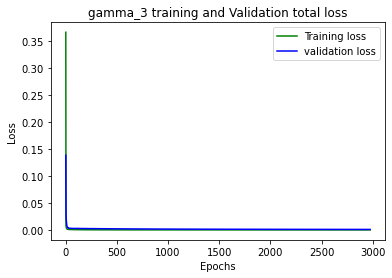

In [10]:
gamma3_dat = np.loadtxt("sd_gamma3.dat.txt", dtype=float)
gamma_3 = single_gamma_prediction(m1_dat, m2_dat, l1_dat, l2_dat, gamma3_dat, "gamma_3",5000,500)

In [11]:
len(gamma_3)

70

# 1 predicted EOS in mass density v enthalpy pressure space

In [67]:
# gamma values

firstgam0 = float(gamma_0[1])
firstgam1 = float(gamma_1[1])
firstgam2 = float(gamma_2[1])
firstgam3 = float(gamma_3[1])


In [68]:
pred_EOS = lal.SimNeutronStarEOS4ParameterSpectralDecomposition(firstgam0, firstgam1, firstgam2, firstgam3)

In [69]:
pred_hmin = 0.01
pred_hmax = lal.SimNeutronStarEOSMaxPseudoEnthalpy(pred_EOS)

pred_loghmin = np.log10(pred_hmin)
pred_loghmax = np.log10(pred_hmax)

pred_h_array = np.linspace(pred_loghmin,pred_loghmax,100)

pred_density = []
pred_pressure = []

for h in pred_h_array:
    pred_density.append(lal.SimNeutronStarEOSRestMassDensityOfPseudoEnthalpy(10**h,pred_EOS))
    pred_pressure.append(lal.SimNeutronStarEOSPressureOfPseudoEnthalpy(10**h,pred_EOS))

pred_density = np.array(pred_density)
pred_pressure = np.array(pred_pressure)

#cgs units
pred_density_cgs = pred_density * 1e-3
pred_pressure_cgs = pred_pressure * 10

pred_logdensity = np.log10(pred_density_cgs)
pred_logpressure = np.log10(pred_pressure_cgs)

(32.0, 37.0)

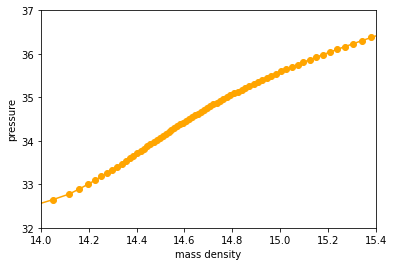

In [70]:
plt.plot(pred_logdensity,pred_logpressure,marker = 'o',color = "orange")
plt.xlabel("mass density")
plt.ylabel("pressure")
plt.xlim([14,15.4])
plt.ylim([32,37])

# all predicted EOS's mass density vs enthalpy pressure space

In [ ]:
warnings.filterwarnings("ignore", category=FutureWarning)

count = 0
numbad = 0

for i in range(len(gamma_0)-1):  #for i in range(len(sd_gamma0))
    try: 
        knowngam0 = float(gamma_0[i])
        knowngam1 = float(gamma_1[i])
        knowngam2 = float(gamma_2[i])
        knowngam3 = float(gamma_3[i])
    
        realEOS = lal.SimNeutronStarEOS4ParameterSpectralDecomposition(knowngam0,knowngam1,knowngam2,knowngam3)
    
        real_h = np.linspace(0.0001,lal.SimNeutronStarEOSMaxPseudoEnthalpy(realEOS),1000)
    
        real_hmin = 0.0001
        real_hmax = lal.SimNeutronStarEOSMaxPseudoEnthalpy(realEOS)
    
        real_loghmin = np.log10(real_hmin)
        real_loghmax = np.log10(real_hmax)

        real_rho = []
        real_p = []

        for k in range(len(real_h)):
            real_rho.append(lal.SimNeutronStarEOSRestMassDensityOfPseudoEnthalpy(real_h[k],realEOS)*.001)
            real_p.append(lal.SimNeutronStarEOSPressureOfPseudoEnthalpy(real_h[k],realEOS)*10)
            
        real_rho = np.array(real_rho)
        real_p = np.array(real_p)

        plt.plot(np.log10(real_rho),np.log10(real_p),alpha=0.25,color='blue')
        
        plt.xlabel("mass density")
        plt.ylabel("pressure")
        
        count += 1
        print(count)
        
    except:
        count += 1
        numbad += 1
        print(count, " no good", knowngam0,knowngam1,knowngam2,knowngam3)
    
    
plt.xlim([14,15.4])
plt.ylim([32,37])
plt.xlabel("mass density")
plt.ylabel("pressure")
plt.show() 


In [13]:
print("There were", numbad, "bad samples.")

There were 25 bad samples.
